[View in Colaboratory](https://colab.research.google.com/github/RaulMedeiros/Neural_Nets/blob/master/Convolutional_Neural_Network_(CNN).ipynb)

# CNN for image classification

In [0]:
src_drive_folder_id = '1PaoYzPEJd_CDRHyl7PpETAV8vjc82ZZ4'
filename = ['dataset.zip']
out_drive_folder_id = '12Bx_3dh4LbSTb4xfjDpHCSwSfCZW35NF'

batch_size = 32
epochs = 12

## Authenticate PyDrive client

In [0]:
# Install the PyDrive wrapper & import libraries.
# This only needs to be done once per notebook.
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

## Import File from drive

In [0]:
!rm -r dataset

In [6]:
# !pip3 install -q pandas
import pandas as pd
import os

def load_and_unzip_file(folder_id,filename):
  """Download and unzip dataset"""   

  info = pd.DataFrame(drive.ListFile({'q': "'"+folder_id +"' in parents and trashed=false" }).GetList())  
  
  for i, drive_filename in enumerate(info['title'].values):
    print(drive_filename)
    if (drive_filename in filename):  
      zip_id = info['id'].values[i]
      zip_title = info['title'].values[i]
  
      downloaded = drive.CreateFile({'id': zip_id })
      downloaded.GetContentFile(zip_title)  

      os.system("unzip -q "+zip_title)
      os.system("rm "+zip_title)
      !ls
  return True

if (src_drive_folder_id):
  #Load and Unconpress data
  load_and_unzip_file(src_drive_folder_id,filename)
else:
  print("Warnning! Drive ID Not Provided")
  
  

dataset.zip
adc.json  out  sample_data


# DATA

### Load Data

In [7]:
!mv out dataset
!ls

dataset_path = 'dataset'

adc.json  dataset  sample_data


In [0]:
import cv2
import numpy as np
import glob

def load_data(path,img_shape=None):
  X = []; y = []
  for img_path in glob.glob(path+'/*/'+'*'):
    # Load an color image in grayscale
    data = cv2.imread(img_path,0)
    label = int(img_path.split('/')[-2])
    
    #Resize (assert image shape)
    if(img_shape and data.shape != img_shape):
      data = cv2.resize(data, tuple(np.flip(img_shape,0))) 

    #Store
    X.append(data) 
    y.append(label) 
  return np.array(X), np.array(y)
  
dataset_path ='dataset'
(X, y) = load_data(dataset_path)
num_classes = len(np.unique(y))


In [9]:
# the data, split between train and test sets
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split( X, y, 
                                                     test_size=0.2,
                                                     random_state=42)

print( " x_train:",x_train.shape, "\n",
        "y_train:", y_train.shape,"\n",
        "x_test:", x_test.shape,  "\n",
        "y_test:", y_test.shape )

 x_train: (5440, 28, 28) 
 y_train: (5440,) 
 x_test: (1360, 28, 28) 
 y_test: (1360,)


###Plots a random samples from the training dataset.

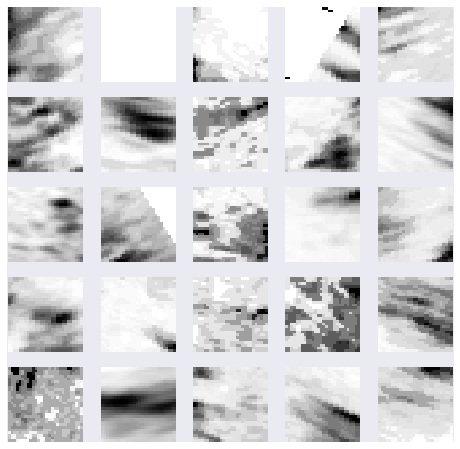

In [10]:
import matplotlib.pyplot as plt
import numpy as np

def plot_images(imgs,columns=5,rows=5,figsize=(8, 8),subplot_size=(10,10)):
  fig=plt.figure(figsize=figsize)
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  for i in range(1, columns*rows+1):
      rand_idx = np.random.randint(len(imgs))
      img = imgs[rand_idx]
      fig.add_subplot(rows, columns, i)
      plt.grid(False)
      plt.xticks([])
      plt.yticks([])
      plt.imshow(img)
  plt.show()
  
plot_images(x_train)

### Normalize images between 0 and 1.

In [11]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= np.max(x_train)
x_test /= np.max(x_test)

print('min:',np.min(x_train),'max:',np.max(x_train))

min: 0.0 max: 1.0


### Convert labes to One-Hot Format.

In [12]:
import keras

print("num of classes:",num_classes,"| label:",y_train[0])
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)
print(y_train[0])

num of classes: 2 | label: 1
[0. 1.]


#  Convolution Neural Network (CNN)


### Format images to the order requested by Tensflow backgroud API.

In [13]:
img_rows = x_train.shape[-2]
img_cols =x_train.shape[-1]

x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
input_shape = (img_rows, img_cols, 1)

x_train.shape, x_test.shape

((5440, 28, 28, 1), (1360, 28, 28, 1))

### Build Model

In [14]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D

model = Sequential()

model.add(Conv2D(filters=64, # Number of Filter / kernel / Neurons
                 kernel_size=(3, 3), 
                 activation='relu', # Activation Function
                 input_shape=input_shape))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Dropout(0.5))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(Dropout(0.5))


model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 64)        640       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 64)        36928     
_________________________________________________________________
dropout_1 (Dropout)          (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 22, 22, 64)        36928     
_________________________________________________________________
dropout_2 (Dropout)          (None, 22, 22, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 30976)             0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 30976)             0         
__________

# TRAIN and EVALUATE

### Set the training configurations: loss (objetctive func.), optimization strategy and the evaluation metric.

In [0]:
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer='adam',
              metrics=['accuracy'])

In [23]:
%%time
history = model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))

Train on 5440 samples, validate on 1360 samples
Epoch 1/12
5440/5440 [==============================] - 3s 642us/step - loss: 0.5007 - acc: 0.7939 - val_loss: 0.5541 - val_acc: 0.7765
Epoch 2/12
5440/5440 [==============================] - 3s 628us/step - loss: 0.4984 - acc: 0.7943 - val_loss: 0.5608 - val_acc: 0.7757
Epoch 3/12
5440/5440 [==============================] - 3s 630us/step - loss: 0.4991 - acc: 0.7943 - val_loss: 0.5582 - val_acc: 0.7779
Epoch 4/12
5440/5440 [==============================] - 3s 630us/step - loss: 0.4956 - acc: 0.7949 - val_loss: 0.5603 - val_acc: 0.7765
Epoch 5/12
5440/5440 [==============================] - 3s 630us/step - loss: 0.4985 - acc: 0.7965 - val_loss: 0.5871 - val_acc: 0.7721
Epoch 6/12
5440/5440 [==============================] - 3s 628us/step - loss: 0.4975 - acc: 0.7928 - val_loss: 0.5586 - val_acc: 0.7757
Epoch 7/12
5440/5440 [==============================] - 3s 630us/step - loss: 0.4938 - acc: 0.7945 - val_loss: 0.5604 - val_acc: 0.7735


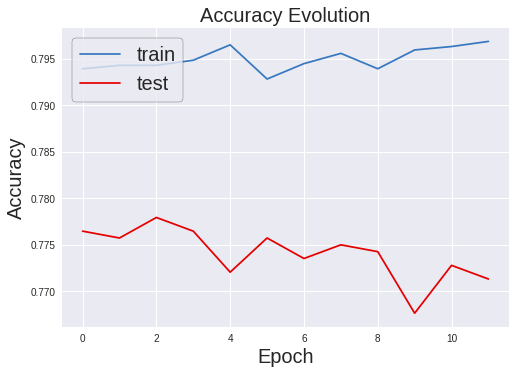

True

In [38]:
import seaborn as sns

def plot_history(history,show=True,fontsize=20):
     
    colors = ["windows blue","red"]
    clrs = sns.xkcd_palette(colors)

    # summarize history for accuracy
    plt.plot(history['acc'],c=clrs[0],label='Train')
    plt.plot(history['val_acc'],c=clrs[1],label='Test')
    plt.grid(True)    
    plt.title('Accuracy Evolution',fontsize=fontsize,)
    plt.ylabel('Accuracy',fontsize=fontsize,)
    plt.xlabel('Epoch',fontsize=fontsize,)
    leg = plt.legend(['train', 'test'],
                     loc='upper left',
                     fontsize=fontsize,
                     frameon=True)
    leg.get_frame().set_edgecolor('black')

    if (show): 
      plt.show()
    else: 
      plt.clf()
    return True
  
plot_history(history.history)

### Compute Evaluation Metric

In [17]:
y_pred = model.predict(x_test)

# computes 
y_test_class = np.argmax(y_test,axis=1)
y_pred_class = np.argmax(y_pred,axis=1)

#Evaluation metrics
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(y_test_class,y_pred_class))

             precision    recall  f1-score   support

          0       0.78      1.00      0.88      1064
          1       0.00      0.00      0.00       296

avg / total       0.61      0.78      0.69      1360



# Visualize

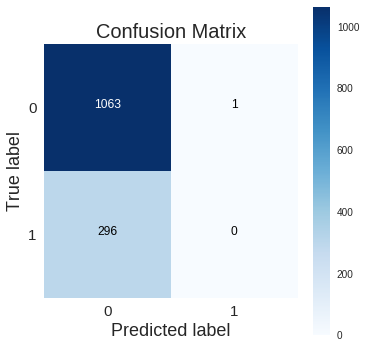

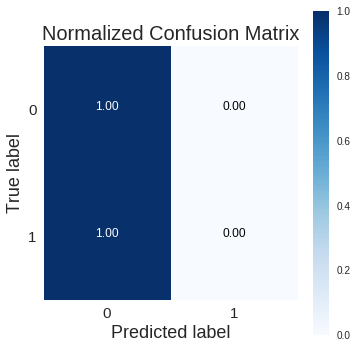

In [18]:
import matplotlib.pyplot as plt
import itertools

'''http://scikit-learn.org/stable/auto_examples/model_selection/
   plot_confusion_matrix.html with minor changes'''

def plot_confusion_matrix(cm, classes=[],
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues,
                          fontsize=20):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if (not classes):
        classes = list(map(str,np.arange(len(cnf_matrix))))     
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
#         print("Normalized confusion matrix")
#     else:
#         print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title,fontsize=fontsize)
    plt.colorbar()
    
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes,fontsize=fontsize-5)
    plt.yticks(tick_marks, classes,fontsize=fontsize-5)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.grid(False)
    plt.ylabel('True label',fontsize=fontsize-2)
    plt.xlabel('Predicted label',fontsize=fontsize-2)
    return True

# Compute Confusion Matrix
cnf_matrix = confusion_matrix(y_test_class,y_pred_class)

# Plot non-normalized confusion matrix
plt.figure(figsize=(5,5))
plot_confusion_matrix(cnf_matrix,
                      title='Confusion Matrix',
                      fontsize=20)

# Plot normalized confusion matrix
plt.figure(figsize=(5,5))
plot_confusion_matrix(cnf_matrix, normalize=True,
                      title='Normalized Confusion Matrix',
                      fontsize=20)

plt.show()